# Two Sigma Financial Modeling #

## Ideas ##
* Impute with local mean
* keep track of moving averages of features
* single and double derivative as features
* use a moving average of past y values weighted with reward
* use difference from expected time series value for feature as a feature

In [1]:
from kagglegym import make
import kagglegym
import numpy as np
import pandas as pd
import random
import xgboost as xgb
from sklearn import ensemble, linear_model, metrics
from sklearn.linear_model import LinearRegression, ElasticNetCV, RANSACRegressor, Ridge 
from sklearn.preprocessing import Imputer, normalize
from sklearn.feature_selection import RFE
from sklearn import feature_selection
import time
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# constants
# random seed
rnd = 0
# timestamp of train/validation split
train_split = 700

In [3]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [4]:
class Model():
    def __init__(self, model, train, validation, columns):

        # first save the model ...
        self.model   = model
        self.columns = columns
        
        # Get the X, and y values, 
        X_train = train[columns]
        y_train = np.array(train.y)
        X_val = validation[columns]
        y_val = np.array(validation.y)
        
        # fit the model
        self.model.fit(X_train, y_train)
        reward = get_reward(y_val, self.model.predict(X_val))
        score = self.model.score(X_val, y_val)
        
        print "{} columns: {} validation: {} score: {}".format(
            str(self.model).split('(')[0], 
            str(columns),
            "{0:.8f}".format(reward),
            "{0:.8f}".format(score))
    
    def predict(self, features):   
        return self.model.predict(features)

In [5]:
def checkModel(modelToUse, columns):
    '''
        This  function checks and makes sure that the 
        model provided is doing what it is supposed to
        do. This is a sanity check ...
    '''
    
    rewards = []
    env = kagglegym.make()
    observation = env.reset()
    
    train = observation.train
    
    # Just to make things easier to visualize
    # and also to speed things up ...
    # -----------------------------------------
    train   = train[['timestamp', 'y'] + columns]
    train   = train.groupby('timestamp').aggregate(np.mean)
    train.y = np.cumsum(train.y) # easier to visualize
    
    print('fitting a model')
    model = fitModel(modelToUse, train, columns)
    
    print('predict the same data')
    yHat = model.predict(train) # We already select required columns
    
    plt.figure()
    plt.plot(yHat, color='black', lw=2, label='predicted')
    plt.plot(train.y, '.', mec='None', mfc='orange', label='original')
    plt.legend(loc='lower right')
    
    return



fitting a model
Model score: 0.660532356677
predict the same data
fitting a model
Model score: 0.991680552331
predict the same data
fitting a model
Model score: 0.963758309785
predict the same data


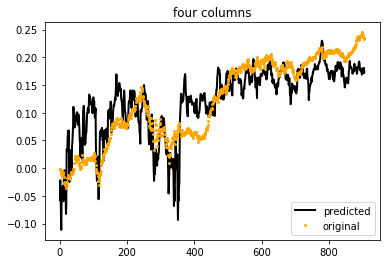

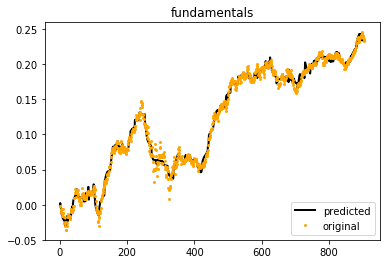

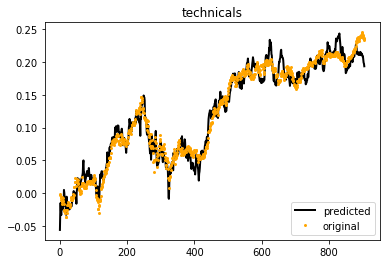

In [5]:
columns = ['technical_30', 'technical_20', 'fundamental_11', 'technical_19']
checkModel(LinearRegression(), columns)
plt.title('four columns')
    
# Get all columns here 
env     = kagglegym.make()
allCols = env.reset().train.columns

checkModel(LinearRegression(), [c for c in allCols if 'fundamental' in c])
plt.title('fundamentals')

checkModel(LinearRegression(), [c for c in allCols if 'technical' in c])
plt.title('technicals')

In [6]:
def getScore(modelToUse, columns):
    
    print('Starting a new calculation for score')
    rewards = []
    env = kagglegym.make()
    observation = env.reset()
    
    print('fitting a model')
    model = fitModel(modelToUse, observation.train.copy(), columns)

    print('Starting to fit a model')
    while True:
        
        prediction  = model.predict(observation.features.copy())
        target      = observation.target
        target['y'] = prediction
        
        timestamp = observation.features["timestamp"][0]
        if timestamp % 100 == 0:
            print(timestamp)

        observation, reward, done, info = env.step(target)
        rewards.append(reward)
        if done: break
            
    return info['public_score'], rewards

In [7]:
# initialize kaggle gym environment
env = make()
o = env.reset()

In [8]:
raw_train = o.train
raw_train["nbnulls"]=raw_train.isnull().sum(axis=1)

In [11]:
# averages_by_ts = raw_train.groupby('timestamp').aggregate(np.mean)
# offset_averages = averages_by_ts.shift(1)
# added_features = averages_by_ts.join(offset_averages, how='inner', rsuffix='_offset')
# raw_train = raw_train.join(added_features, on='timestamp', how='left', rsuffix='_rolling')

In [12]:
averages_by_ts.shape
raw_train = raw_train.join(added_features, on='timestamp', how='left', rsuffix='_rolling')

In [19]:
raw_train.shape
raw_train = raw_train.fillna(0)

In [22]:
print raw_train[['technical_20', 'technical_30']].dtypes

technical_20    object
technical_30    object
dtype: object


In [21]:
raw_train[['technical_20']].convert_objects(convert_numeric=True).dtypes

/home/ryan/Libraries/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


technical_20    float64
dtype: object

In [15]:
m = linear_model.LinearRegression()

print raw_train[['technical_20']].dtypes
print raw_train.y

technical_20    object
dtype: object
0        -0.011753
1        -0.001240
2        -0.020940
3        -0.015959
4        -0.007338
5         0.031425
6        -0.032895
7         0.015803
8        -0.027593
9         0.006662
10       -0.001899
11        0.050219
12       -0.018991
13       -0.005203
14       -0.006369
15        0.017768
16       -0.001089
17       -0.008794
18        0.040724
19       -0.003921
20       -0.011317
21        0.044167
22        0.001395
23       -0.012101
24       -0.070837
25       -0.001766
26       -0.012542
27        0.029697
28        0.030815
29       -0.016336
            ...   
806268   -0.019695
806269   -0.002233
806270    0.003430
806271    0.015341
806272    0.001687
806273   -0.009780
806274    0.002069
806275   -0.002455
806276   -0.014750
806277   -0.001223
806278    0.001871
806279   -0.017363
806280    0.020699
806281    0.014171
806282    0.005206
806283   -0.001401
806284    0.018129
806285    0.019033
806286    0.026371
806287    0.0

In [14]:
m.fit(raw_train[['technical_20']], raw_train.y.values)

TypeError: float() argument must be a string or a number

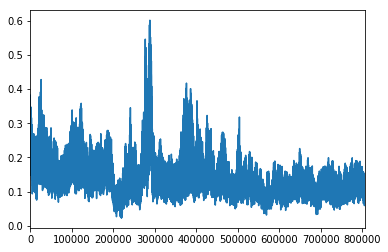

In [79]:
raw_train['technical_20_rolling'].plot()

In [14]:
raw_train['technical_20_rolling'][:10]

0    0.002632
1    0.002632
2    0.002632
3    0.002632
4    0.002632
5    0.002632
6    0.002632
7    0.002632
8    0.002632
9    0.002632
Name: technical_20_rolling, dtype: float32

In [9]:
#%time raw_train = o.train.fillna(o.train.rolling(min_periods=0, window=100).median())
%time raw_train = raw_train.fillna(np.median)

CPU times: user 5.68 s, sys: 428 ms, total: 6.11 s
Wall time: 6.12 s


In [129]:
estimator = xgb.XGBRegressor()
selector = RFE(estimator, 4, step=25, verbose=1)
#selector = feature_selection.SelectFromModel(estimator)

In [130]:
fr = selector.fit(raw_train.drop('y',1), raw_train.y.values)

Fitting estimator with 111 features.
Fitting estimator with 86 features.
Fitting estimator with 61 features.
Fitting estimator with 36 features.
Fitting estimator with 11 features.


In [131]:
selections = [i for i, x in enumerate(fr.get_support()) if x]
print np.array(raw_train.columns.get_values())[selections]

[u'timestamp' u'fundamental_53' u'technical_3' u'technical_30']


In [132]:
estimator = linear_model.RANSACRegressor()
selector = RFE(estimator, 4, step=25, verbose=1)
#selector = feature_selection.SelectFromModel(estimator)
fr = selector.fit(raw_train.drop('y',1), raw_train.y.values)
selections = [i for i, x in enumerate(fr.get_support()) if x]
print np.array(raw_train.columns.get_values())[selections]

Fitting estimator with 111 features.


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [109]:
# split train and validation sets
train = raw_train[raw_train['timestamp'] < train_split]
val = raw_train[raw_train['timestamp'] > train_split]

In [21]:
model_dict = {}

In [40]:
columns = ['technical_30', 'technical_20', 'technical_40']
#columns = ['technical_30', 'technical_20', 'technical_44', 'fundamental_11' ,'fundamental_18' ,'fundamental_19' ,'fundamental_20'
# ,'fundamental_22' ,'fundamental_24', 'nbnulls']
#columns = ['fundamental_11' ,'fundamental_20' ,'fundamental_53' ,'technical_20'



#columns = raw_train.columns[selections]
model_dict['elasticNet'] = Model(linear_model.RANSACRegressor(), train, val, columns)

RANSACRegressor columns: ['technical_20'] validation: -0.11737439 score: -0.01377666


In [163]:

getScore(ElasticNetCV(), columns)[0]

Starting a new calculation for score
fitting a model


NameError: global name 'fitModel' is not defined

In [4]:
# see which instance variables we have access to
print o.__dict__.keys()

['train', 'target', 'features']


In [5]:
d_median = o.train.median(axis=0)
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
raw_train = pd.DataFrame(fill_NaN.fit_transform(o.train))
raw_train.columns = o.train.columns
raw_train.index = o.train.index

In [83]:
raw_train['cumsum'] = raw_train['y'].cumsum()
raw_train['y_prev'] = raw_train['y'].shift(1)
raw_train = raw_train.fillna(0)

In [84]:
# split train and validation sets
train = raw_train[raw_train['timestamp'] < train_split]
val = raw_train[raw_train['timestamp'] > train_split]

In [85]:
scores = []
models = {}
for i in range(len(train.columns)):
    model = linear_model.Ridge(fit_intercept=False, normalize=True, copy_X=True)
    model.fit(train.ix[:,i].to_frame(), train.y.values)
    models[train.columns[i]] = model
    scores.append(model.score(val.ix[:,i].to_frame(), val.y.values))
scores = np.array(scores)

In [93]:
y_prev_model=  linear_model.ElasticNetCV(normalize=True)
y_prev_model.fit(train['y_prev'].to_frame(), train.y.values)
predz = y_prev_model.predict(val['y_prev'].to_frame())

In [86]:
np.sort(scores)
print scores[-4:]

[ -4.64790085e-04  -1.17527007e-04  -4.37854630e-05  -3.81959791e-04]


In [87]:
sorted_scores = scores.argsort()

In [88]:
print sorted_scores
print train.columns[sorted_scores]

[225 114   3 242 131 123 234 268 157 284  20 173 136 247  45 250 139 262
  28 184 151 295 100 101 179 290  68 204 159 270 315 318 207  62  88  40
  99  59  87  25 220  65  58  78 331  92  22  98 255  17  18  37  71  86
  55  82   9 144 199 332  57  93 202  15 310  38 162 137  49  89 273 248
 134  47  73   7 226 313 115  11  23  90   4  64  74  10 117 228  36  83
 106 109   5 264 153  54 150 261   6  42  39 289 178  67   8 230 119  32
  13  26  51 143 254 293 182 235 124   2  56  29  24  35  46  41  44  91
  16  53  96  33  61  50 118 229 245  31  12  63 116 251 278 227 224 113
  48  81  21 168 192 296 167  30 140  94 103  43 102  77  27  34 279 276
 107  60  66 303 188  70 322 185 165  85 211 104 269 299  19  97 111 335
 323 105 158 212  69 266  14  52 197 155 308  80 206  76 170 281 128 108
 203 121 232 239 314 208 210 317 283 258 172 319 216 200 148  72 145 259
 147 198 320 256 146 309 257 321 327 195 306  84 209 183 311 120  79 263
 294 138 231 249 152  75 246 161 163 328 274 272 26

In [73]:
predictions = models['derived_1' ].predict(val['derived_1'].to_frame())

In [70]:
env = make()
o = env.reset()
print('Starting a new calculation for score')
rewards = []

print('Starting to fit a model')
while True:
    features = o.features.copy().fillna(0)
    averages_by_ts = features[['technical_42', 'timestamp']].groupby('timestamp').aggregate(np.mean)
    features = features.join(averages_by_ts, on='timestamp', how='left', rsuffix = '_rolling')
    features['technical_42_rolling']
    prediction  = models['technical_42_rolling'].predict(features['technical_42_rolling'].to_frame())
    target      = o.target
    target['y'] = prediction

    timestamp = o.features["timestamp"][0]
    if timestamp % 100 == 0:
        print(timestamp)

    o, reward, done, info = env.step(target)
    rewards.append(reward)
    if done: break

print info['public_score']

Starting a new calculation for score
Starting to fit a model
1000
1100
1200
1300
1400
1500
1600
1700
1800
-0.0182640812381


In [74]:
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [94]:
print get_reward(val.y.values, predz)

0.0116063756106


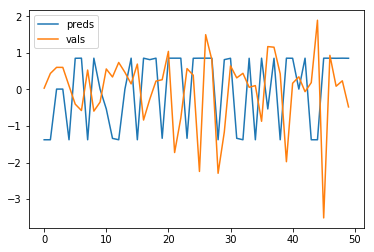

In [113]:
x_size = 50
s_preds = (predictions[:x_size]- np.mean(predictions[:x_size], axis=0)) / np.std(predictions[:x_size], axis=0)
s_vals = (val_labels[:x_size] - np.mean(val_labels[:x_size], axis=0)) / np.std(val_labels[:x_size], axis=0)


plt.plot(s_preds)
plt.plot(s_vals)
plt.legend(('preds', 'vals'),)
plt.show()

In [ ]:
predictions[:10]


In [ ]:
val_labels[:10]